In [1]:
from pylab import *

import arviz as az
import h5py
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

In [2]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

# PSD

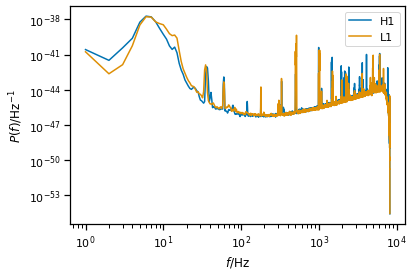

In [3]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

In [4]:
fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
T=0.2
srate=2048

fit.result = az.from_netcdf('./srate'+str(srate)+'-0p2s-32sdata.nc')

fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)

In [5]:
fit.compute_acfs()

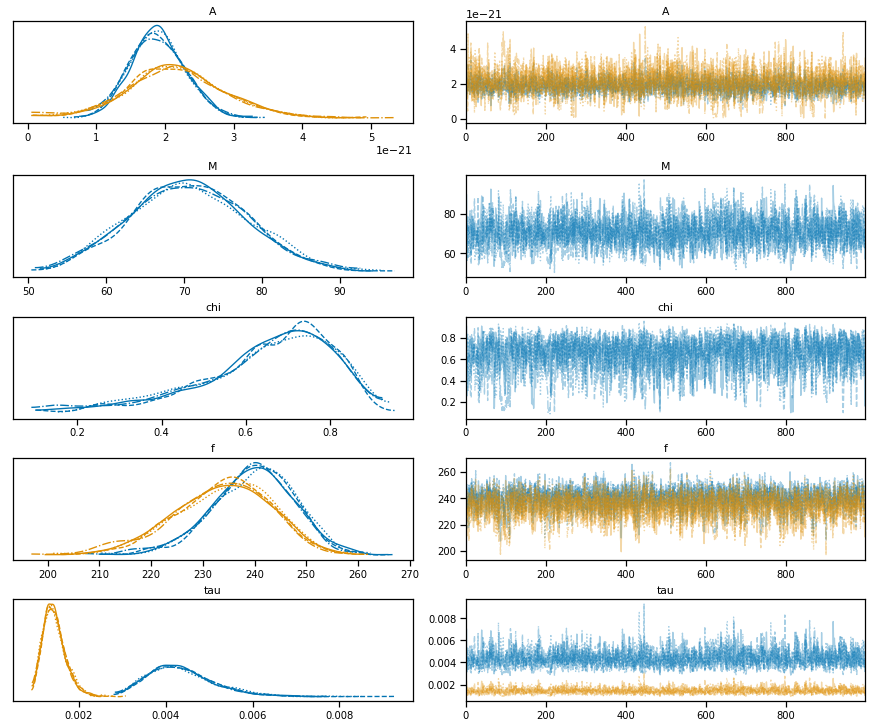

In [6]:
az.plot_trace(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

## SNRs from 4000 samples

In [7]:
L = [a.iloc[:fit.n_analyze].cholesky for a in fit.acfs.values()]
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
data_pd = fit.analysis_data
data_dict = list(data_pd.values())

In [8]:
def rd_snr(L,hs,data=None,optimal=True, network=True) -> np.ndarray:
    '''
    L: cholesky factor
    hs: h strain
    data: raw data
    '''
    whs = linalg.solve(L, hs)
    opt_ifo_snrs = linalg.norm(whs, axis=1)
    if optimal:
        snrs = opt_ifo_snrs
    else:
        # whiten it with the Cholesky factors, so shape will remain (ifo, time)
        wdata = linalg.solve(L, data)
        # take inner product between whitened template and data, and normalize
        snrs = einsum('ijk,ij->ik', whs, wdata)/opt_ifo_snrs
    if network:
        # take norm across detectors
        return linalg.norm(snrs, axis=0)
    else:
        return snrs

In [9]:
optsnr = rd_snr(L,hs,data=None,optimal=True,network=True)

In [10]:
mfsnr = rd_snr(L,hs,data_dict,optimal=False,network=True)

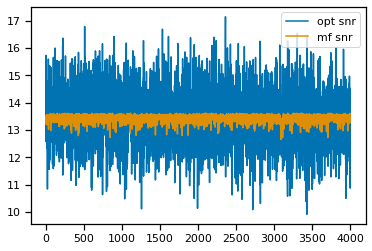

In [11]:
plot(optsnr,label='opt snr')
plot(mfsnr,label='mf snr')
legend()

# PyRing 8192Hz run

In [12]:
from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise

from tqdm import tqdm

/work/yifan.wang/virtualenv/ringdown/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [13]:
# stacking the posterior h_det and parameters
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
A = fit.result.posterior.A.stack(samples=('chain','draw'))
phi = fit.result.posterior.phi.stack(samples=('chain','draw'))
M = fit.result.posterior.M.stack(samples=('chain','draw'))
chi = fit.result.posterior.chi.stack(samples=('chain','draw'))

In [14]:
import sys,importlib
sys.path.append("/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/")
from pyring_par import *
import data
import wheel
import plot

In [15]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':4096,
                'sampling-rate': 8192, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*8192),
                'likelihood-method':'direct-inversion',
                'split-inner-products':0,
                'debug':0})
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 4096] Hz.
Downsampling detector data from 16384.0 to 8192 Hz, decimate factor 2
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0663548126991098

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 4096] Hz.
Downsampling detector data from 16384.0 to 8192 Hz, decimate factor 2
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

In [16]:
result = wheel.wheel(model)

In [17]:
i = np.argmax(mfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

In [18]:
pr_data  = {}
pr_time  = {}
for d in model.detectors.keys():
    pr_data[d],pr_time[d] = data.local_load_data(d,**test_par)


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 4096] Hz.
Downsampling detector data from 16384.0 to 8192 Hz, decimate factor 2

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 4096] Hz.
Downsampling detector data from 16384.0 to 8192 Hz, decimate factor 2


In [19]:
pr_optsnr_net,pr_mfsnr_net = wheel.compute_multiple_snr(
    model,pr_time,pr_data,M,chi,A,phi,network=True,acf_from_psd=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [04:13<00:00, 15.78it/s]


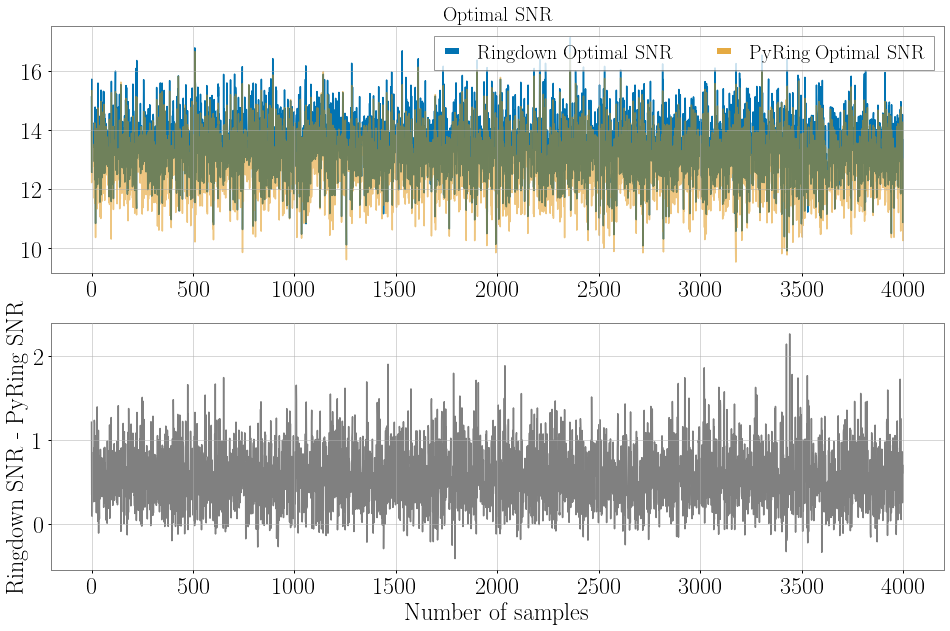

In [20]:
wheel.plotsnr(optsnr,pr_optsnr_net,snr='Optimal SNR')

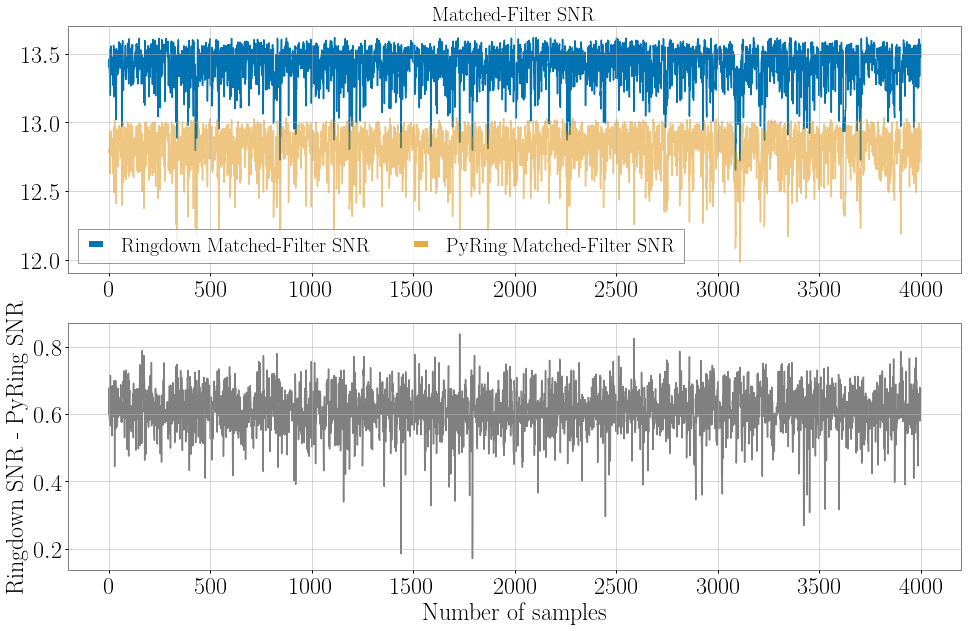

In [21]:
wheel.plotsnr(mfsnr,pr_mfsnr_net,snr='Matched-Filter SNR')

# Plot posterior 

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook')
sns.set_palette('colorblind')

In [23]:
df_pyring = plot.read_pos('/work/yifan.wang/more_ringdown/runs/pyring/0p1-8192/')

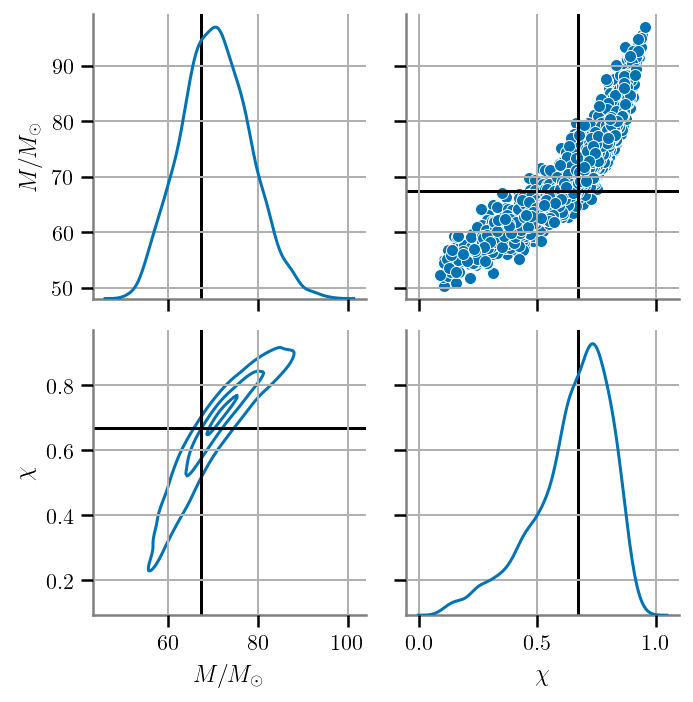

In [24]:
mIMR = 67.4
chiIMR = 0.67

df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

pg.axes[0,0].axvline(mIMR, color='k')
pg.axes[0,1].axvline(chiIMR, color='k')
pg.axes[0,1].axhline(mIMR, color='k')
pg.axes[1,0].axhline(chiIMR, color='k')
pg.axes[1,0].axvline(mIMR, color='k')
pg.axes[1,1].axvline(chiIMR, color='k')

# A221

Text(0.5, 7.9599999999999795, '$A_1$')

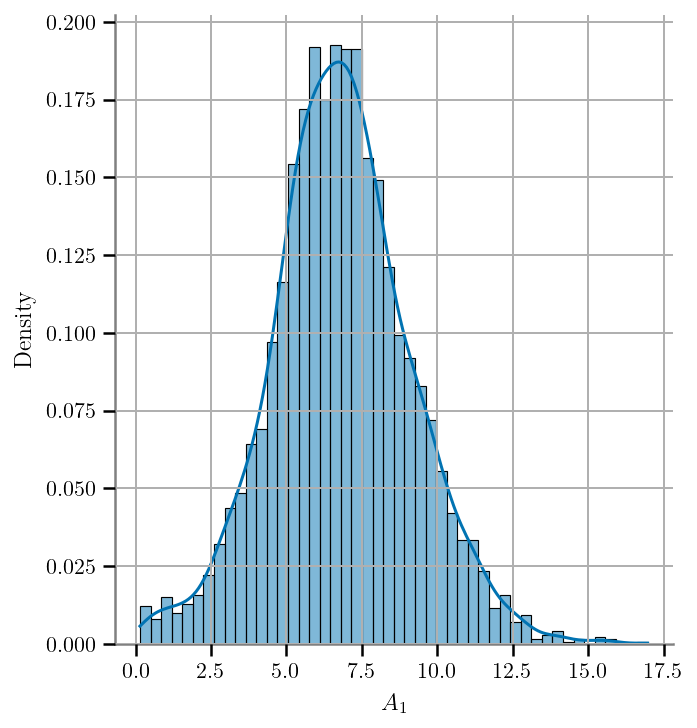

In [25]:
sns.displot(fit.result.posterior.A[:,:,1].values.flatten()/1e-21*prefactor, kde=True, stat='density')
xlabel(r'$A_1$')

In [26]:
rd_a221 = fit.result.posterior.A[:,:,1].values.flatten()
median(rd_a221)/std(rd_a221)

2.940105

Text(0.5, 7.9599999999999795, '$A_1$')

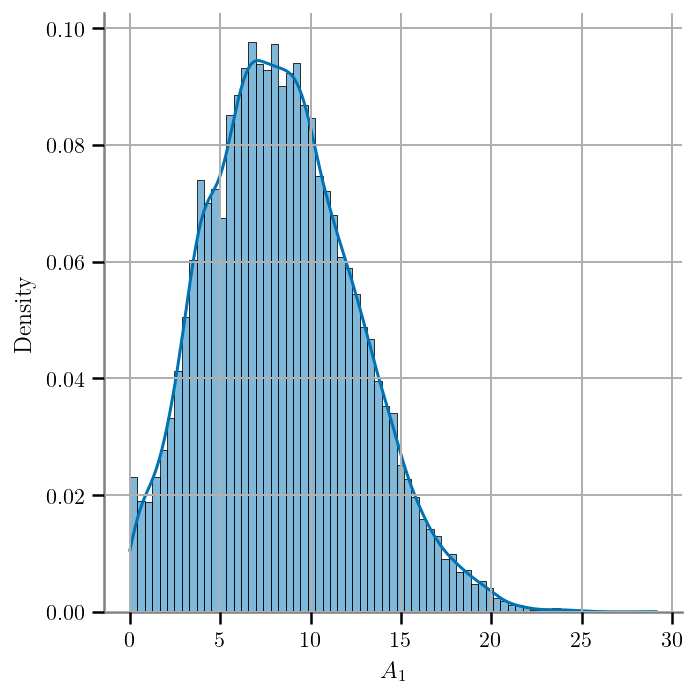

In [27]:
sns.displot(df_pyring['A2221'],kde=True,stat='density')
xlabel(r'$A_1$')

In [28]:
rd_a221 = fit.result.posterior.A[:,:,1].values.flatten()
median(rd_a221)/std(rd_a221)

2.940105

In [29]:
median(df_pyring['A2221'])/std(df_pyring['A2221'])

2.0014878576908552

# PyCBC

In [30]:
from pycbc.inference import io

In [31]:
f = io.loadfile('/work/yifan.wang/ringdown/GW150914/pycbc_run/8192-high20hz/result.hdf','r')

In [32]:
f['samples'].keys()

<KeysViewHDF5 ['absamp221', 'amp220', 'final_mass', 'final_spin', 'loglikelihood', 'logwt', 'phi220', 'phi221']>

In [33]:
pos = f.read_samples(['absamp221'])

Text(0.5, 7.9599999999999795, '$A_1$')

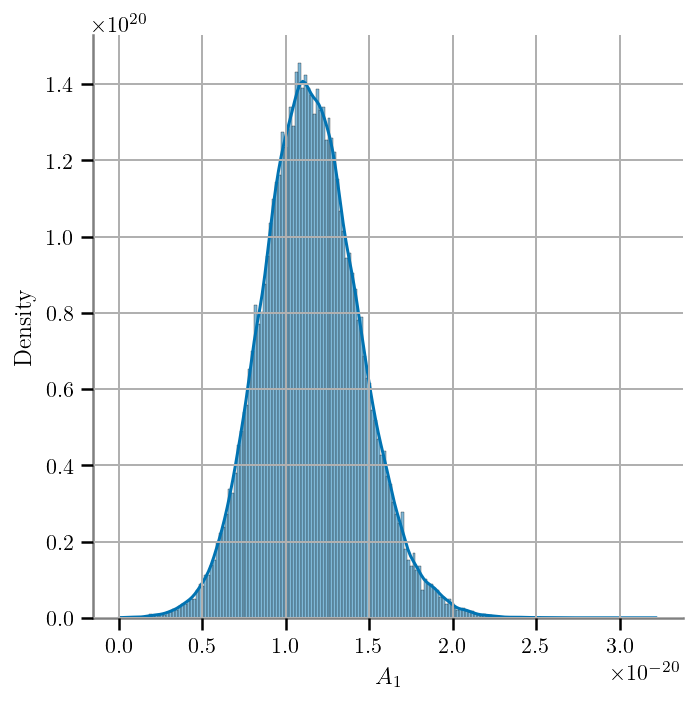

In [34]:
sns.displot(pos['absamp221'],kde=True,stat='density')
xlabel(r'$A_1$')

In [35]:
median(pos['absamp221'])/std(pos['absamp221'])

3.9199025337640028

In [36]:
data = f.read_data()                                                           
psds = f.read_psds()   

(10, 7131.550214521845)

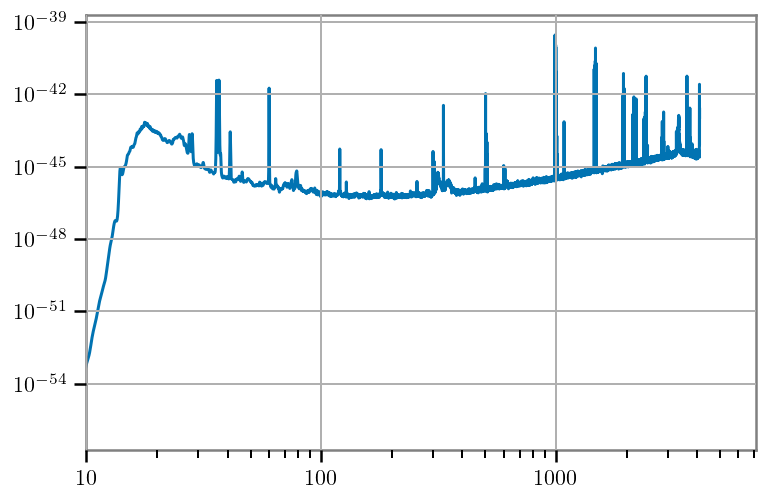

In [37]:
loglog(psds['H1'].sample_frequencies,psds['H1'])
plt.xlim(10,)

# PyCBC doesn't have a steep descent